<img src="connectivity_website.png">  

<h1 align="center">Allen Mouse Brain Connectivity Atlas and SDK</h1>
<h3 align="center">2017 Short Course 2: Neuroinformatics in the Age of Big Data: Working with the Right Data and Tools</h3>
<h3 align="center">Society for Neuroscience 47th annual meeting
<br>Friday, November 10, 2017</h3>


<p><center>This notebook will introduce you to the Allen Mouse Brain Connectivity Atlas and its associated SDK.</center></p>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #f0f0ff; ">
<h2>Visit the Allen Institute at Booth #501</h2>
<p>
You can find information about our SfN presentations on our website: http://www.alleninstitute.org/what-we-do/brain-science/events-training/sfn17/

<p>
Credits: This notebook was developed by Jennifer Whitesell, Nile Graddis, and David Feng
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #f0f0ff; ">
<h2>Mouse Connectivity SDK</h2>

<p>
Connectivity data can be accessed <a href="http://connectivity.brain-map.org/">on the web</a>. This is useful for browsing and familiarizing yourself with the data, but for more in-depth analyses, it is often better to access data programmatically. The <a href="https://alleninstitute.github.io/AllenSDK/">AllenSDK</a> provides Python-based tools to support that approach, and this notebook will introduce you to them.<p>

<p>
For this workshop, we have preinstalled everything you need on AWS (Amazon Web Services cloud computing platform) where we are hosting this notebook, but to work thorugh this on your own later you will need to install the `allensdk` python module. You can do this from a command prompt:</p>

<p>
   `> pip install allensdk` </p>
    
</div>

In [1]:
# imports! These modules were preinstalled on AWS but you may need to install them on your own computer

# pandas for manipulating / viewing tables
import pandas as pd

# numpy, which needs no introduction
import numpy as np

# os for dealing with the file system
import os

# easy plotting
import matplotlib.pyplot as plt

# MouseConnectivityCache for downloading and storing mouse connectivity data
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache

# OntologiesApi
from allensdk.api.queries.ontologies_api import OntologiesApi

In [2]:
# Settings! 

# This makes our plots appear inside the notebook
%matplotlib inline 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #f0f0ff; "><h4>The caching pattern:</h4>
<p>We will be using the MouseConnectivityCache class to download and store data. This class requires from us:

<ul>
<li>a manifest file path. This path determines where data will be stored. Once you have instantiated your cache once, you can access downloaded data again by instantiating a new cache with the same manifest path.  We will be using pre-populated data directories.</li>
<ul>
<li><i>A MouseConnectivityCache is used to copy and cache data from the cell types database. If you create the MouseConnectivityCache instance with no arguments, then data is downloaded from the online repository:
mcc = MouseConnectivityCache()</i></li>
<p><li><i>Because we have limited internet bandwidth, the data you need is already provided on AWS. To ensure this local data is used instead of the online repository, create the MouseConnectivityCache instance using the manifest_file argument: MouseConnectivityCache(manifest_file='manifest_filename.json')</i></li></p></ul>

<li>a resolution for the data volumes that we will be downloading. The possible (isometric) resolutions are 10, 25, 50, and 100-microns, with 25 the default.</li>
</ul>

<p>As usual, you can use the built in help function to see the complete documentation.</p></div>

In [3]:
# instantiate the cache object
# after this step, the manifest file you specified should exist on your filesystem
mcc = MouseConnectivityCache()

In [4]:
##
help(mcc)

Help on MouseConnectivityCache in module allensdk.core.mouse_connectivity_cache object:

class MouseConnectivityCache(allensdk.core.reference_space_cache.ReferenceSpaceCache)
 |  MouseConnectivityCache(resolution=None, cache=True, manifest_file=None, ccf_version=None, base_uri=None, version=None)
 |  
 |  Cache class for storing and accessing data related to the adult mouse
 |  Connectivity Atlas.  By default, this class will cache any downloaded
 |  metadata or files in well known locations defined in a manifest file.
 |  This behavior can be disabled.
 |  
 |  Attributes
 |  ----------
 |  
 |  resolution: int
 |      Resolution of grid data to be downloaded when accessing projection volume,
 |      the annotation volume, and the annotation volume.  Must be one of (10, 25,
 |      50, 100).  Default is 25.
 |  
 |  api: MouseConnectivityApi instance
 |      Used internally to make API queries.
 |  
 |  Parameters
 |  ----------
 |  
 |  resolution: int
 |      Resolution of grid data

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #f0f0ff; ">
<h2>Working in 3d space</h2>

<p>The Allen Institute has generated an average template volume from 1675 mouse brain image stacks and each of our connectivity datasets is registered to this average template. This allows us to work in a shared 3d space, which we call the Common Coordinate Framework (CCF)</p>

<p>You can view the average template volume using your MouseConnectivityCache:</p>

</div>

(528, 320, 456)


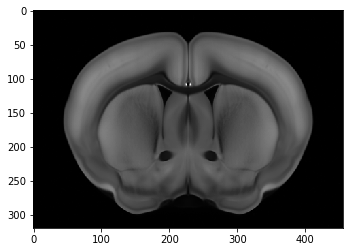

In [5]:
# load up the average template
template, header = mcc.get_template_volume()

# recall that this cache is at 25 micron isometric resolution
plt.imshow(template[200, :, :], interpolation='none', cmap=plt.cm.gray)

# how big?
print(template.shape)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #f0f0ff; ">
<p>The template is oriented:</p>
<ul>
<li>anterior -> posterior</li>
<li>superior -> inferior</li>
<li>left -> right</li>
</ul>

<p>This means that to obtain a sagittal view, we must slice along axis 2, and for a horizontal section we slice along axis 1:</p>
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FFF0; ">
<h4>Exercise 1: Generate sagittal and horizontal sections from the template</h4>
<p></p>
</div>

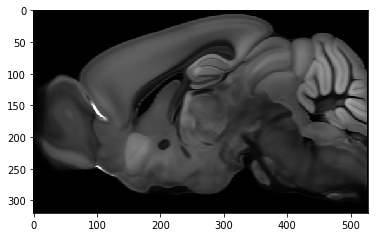

In [6]:
plt.imshow(template[:, :, 200].T, interpolation='none', cmap=plt.cm.gray)

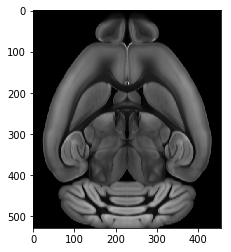

In [7]:
plt.imshow(template[:, 125, :], interpolation='none', cmap=plt.cm.gray)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #f0f0ff; ">
<h4>The annotation volume</h4>

<p>Each (brain) voxel in the CCF is associated with a structure in the structure tree. This mapping is recorded in the annotation volume, which occupies the same space as the average template. The value of each voxel in the annotation volume is the id of the most specific structure occupying that point in space.</p>
</div>

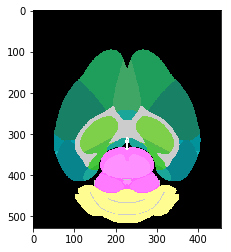

In [8]:
# you can obtain a reference space object from your mouse connectivity cache
# this object handles tasks that require both a structure tree and an annotation volume
reference_space =  mcc.get_reference_space()

# One such task is to apply our predefined structure colors to 
# a slice from the annotation volume
slice_image = reference_space.get_slice_image(1, 1850) # this method wants an axis and a position in microns
plt.imshow(slice_image, interpolation='none')

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #f0f0ff; ">
<h4>Structure masks</h4>

<p>The annotation volume and structure tree contain a lot of information in a compact form. It can be simpler to work with more explicit representations of individual structures. We often use binary indicator masks for specific structures. These are:</p>
<ul>
<li>volumes in the common coordinate framework</li>
<li>1 where the annotation is labeled with a structure or its descendants, otherwise 0</li>
</ul>
</div>

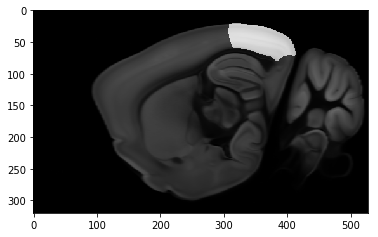

In [59]:
# view a structure mask for primary visual cortex (VISp)
visp_mask, _ = mcc.get_structure_mask(385)
plt.imshow(visp_mask[:, :, 125].T, interpolation='none', cmap=plt.cm.gray)
plt.imshow(template[:, :, 125].T, interpolation='none', cmap=plt.cm.gray, alpha=0.4)

In [10]:
# we can now easily locate VISp-labeled voxels in space:
np.where(visp_mask)

(array([307, 307, 307, ..., 414, 414, 414]),
 array([23, 23, 24, ..., 78, 78, 78]),
 array([121, 335, 119, ..., 338, 339, 340]))

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #f0f0ff; ">
<h2>Working with 3D gridded projection data</h2>

<p>Since each connectivity experiment is registered to the CCF, we can load connectivity data in the same way as we do the average template or annotation volume.</p>

<p>Here we will load an experiment's projection density volume. These data:
<ul>
<li>are floats in [0, 1]</li>
<li>represent the fraction of each voxel that is occupied by signal (as detected in the segmentation stage)</li>
<li>are independent of the injection site (so it makes sense to discuss "projection in the injection site")</li>
</ul></p>
</div>

In [11]:
# get the projection density for one experiment
prdens, _ = mcc.get_projection_density(159550125)

In [12]:
def axis_proj(data, template, axis, bg_q=90, bg_alpha=0.5):
    # visualize projection data along a specified axis
    
    data_max = np.amax(data, axis=axis)
    template_bg = np.percentile(template, axis=axis, q=bg_q)
    
    if axis == 2:
        plt.imshow(data_max.T, interpolation='none', cmap=plt.cm.afmhot)
        plt.imshow(template_bg.T, interpolation='none', cmap=plt.cm.gray, alpha=0.5)
    else:
        plt.imshow(data_max, interpolation='none', cmap=plt.cm.afmhot)
        plt.imshow(template_bg, interpolation='none', cmap=plt.cm.gray, alpha=0.5)

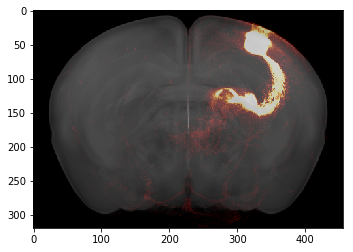

In [13]:
# make a max projection along the anterior-posterior axis for visualization
axis_proj(prdens, template, 0)

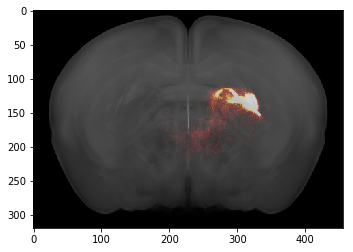

In [14]:
# now filter the signal to thalamus
thalamus_mask, _ = mcc.get_structure_mask(549)

prdens_th = prdens.copy()
prdens_th[thalamus_mask == 0] = 0
axis_proj(prdens_th, template, 0)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #f0f0ff; ">

Another useful data volume is the injection fraction. This shows the fraction of each voxel that lies within this experiment's manually annotated injection site
</div>

In [15]:
ijfr, _ = mcc.get_injection_fraction(159550125)

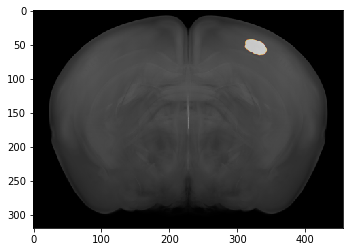

In [16]:
axis_proj(ijfr, template, 0)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FFF0; ">
<h4>Exercise 2: Generate a projection image</h4>
<p>Use the axis_proj function to generate a max projection image of this experiment in the medial-lateral axis (a sagittal projection)</p>
</div>

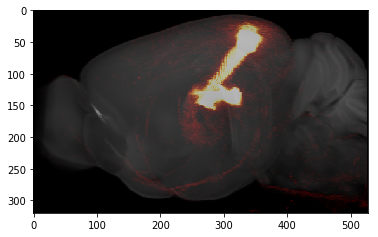

In [17]:
axis_proj(prdens, template, 2)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #f0f0ff; "><h2><center>How to find data that may be useful for your research</center></h2>
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #f0f0ff; "><h2>Ontology and the Structure Tree</h2>
<p>
Anatomists at the Allen Institute have divided the adult mouse brain into ~1300 distinct structures. These are arranged in a tree, where coarsely specified structures (e.g. 'Isocortex') are near the root and finely specified structures (e.g "Primary visual area, layer 4") make up the leaves.

<a href="http://atlas.brain-map.org/atlas?atlas=602630314">Here</a> is a handy visualization of the tree (and atlas!).</p>

<p>You can download and access the structure tree by calling get_structure_tree on your MouseConnectivityCache instance. The methods in structure_tree are useful for navigating the atlas and connectivity data.</p></div>

In [18]:
# get the structure tree
# this step should produce a file called 'structures.json' in the same directory as your manifest file
structure_tree = mcc.get_structure_tree()

In [19]:
# view the structure record for primary visual cortex
visp = structure_tree.get_structures_by_name(['Primary visual area'])

# the data structure returned by this method is a list of dictionaries:
visp

[{'acronym': 'VISp',
  'graph_id': 1,
  'graph_order': 185,
  'id': 385,
  'name': 'Primary visual area',
  'structure_id_path': [997, 8, 567, 688, 695, 315, 669, 385],
  'structure_set_ids': [396673091,
   112905828,
   688152357,
   691663206,
   687527945,
   12,
   184527634,
   514166994,
   112905813,
   167587189,
   114512891,
   114512892],
  'rgb_triplet': [8, 133, 140]}]

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #f0f0ff; ">
See <a href='http://alleninstitute.github.io/AllenSDK/_static/examples/nb/reference_space.html'>here</a> for definitions of these fields. The most relevant ones for us right now are:

<ul>
<li>id: A unique integer identifier for this structure</li>
<li>name: The structure's full name</li>
<li>acronym: A shortened version of the structure's name</li>
<li>structure_id_path: a list of structures from the root of the tree (left) to the selected structure record.</li>
</ul>
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FFF0; ">
<h4>Exercise 3: Working with structures</h4>
<p>Find the structure id for the structure of your choice. Use the id to get the mask for that structure. Plot it on the template.</p>
</div>

#### Find the name of your structure here: http://atlas.brain-map.org/atlas?atlas=602630314


In [20]:
your_structure = structure_tree.get_structures_by_name(['Anterior cingulate area, dorsal part'])

In [21]:
your_structure

[{'acronym': 'ACAd',
  'graph_id': 1,
  'graph_order': 226,
  'id': 39,
  'name': 'Anterior cingulate area, dorsal part',
  'structure_id_path': [997, 8, 567, 688, 695, 315, 31, 39],
  'structure_set_ids': [112905828,
   688152357,
   691663206,
   687527945,
   12,
   184527634,
   167587189,
   114512891],
  'rgb_triplet': [64, 166, 102]}]

In [22]:
your_structure_id = your_structure[0]['id']

In [23]:
your_structure_mask, _ = mcc.get_structure_mask(your_structure_id)
np.where(your_structure_mask)

(array([ 99,  99,  99, ..., 253, 254, 254]),
 array([82, 83, 83, ..., 62, 59, 61]),
 array([216, 216, 240, ..., 258, 198, 197]))

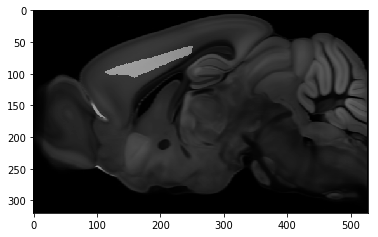

In [24]:
plt.imshow(your_structure_mask[:, :, 200].T, interpolation='none', cmap=plt.cm.gray)
plt.imshow(template[:, :, 200].T, interpolation='none', cmap=plt.cm.gray, alpha=0.6)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #f0f0ff; ">
<h2>Finding Connectivity Experiments</h2>

<p>Which experiments have injections into your structure? On <a href="http://connectivity.brain-map.org">connectivity.brain-map.org</a> you can do a <i>source search</i> to list experiments by the region into which viral tracer was injected. It is possible to do a similar search programmatically using the SDK.</p>
</div>

In [25]:
# get a table of injection experiments. This is a list of dictionaries.
experiments = mcc.get_experiments(injection_structure_ids=[385]) # insert your structure id here

In [26]:
# Most of the Mouse Connectivity Cache functions return results as a list of dictionaries.
print(len(experiments))
print(type(experiments))

283
<class 'list'>


In [27]:
# look at one of them
experiments[150]

{'gender': 'M',
 'injection_structures': [385],
 'injection_volume': 0.0937516412,
 'injection_x': 9250,
 'injection_y': 1010,
 'injection_z': 8210,
 'product_id': 5,
 'specimen_name': 'Rorb-IRES2-Cre-D_LURC-132002',
 'strain': 'C57BL/6J',
 'structure_abbrev': 'VISp',
 'structure_id': 385,
 'structure_name': 'Primary visual area',
 'transgenic_line': 'Rorb-IRES2-Cre',
 'transgenic_line_id': 179697864,
 'id': 301616660,
 'primary_injection_structure': 385}

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #f0f0ff; ">
Some particularly important fields here:
<ul>
<li>id : Like structures, each experiment has a unique id.</li>
<li>injection-structures : This is a list of structures that overlapped the injection site. VISp comes first, indicating that it overlapped most heavily. We call VISp the "primary injection site" for this experiment.</li>
<li>transgenic_line : For wild type injections, this field would be an empty string.</li>
</ul>
</div>

In [28]:
# a list of dictionaries can be directly converted into a dataframe. Syntax:
dat = pd.DataFrame(experiments)
dat.head()

,gender,id,injection_structures,injection_volume,injection_x,injection_y,injection_z,primary_injection_structure,product_id,specimen_name,strain,structure_abbrev,structure_id,structure_name,transgenic_line,transgenic_line_id
0,M,500836840,[385],0.375218,8850,1440,3550,385,36,Emx1-IRES-Cre-212542,None,VISp,385,Primary visual area,Emx1-IRES-Cre,177836119.0
1,M,307297141,"[385, 409]",0.663636,9230,1910,8430,385,5,C57BL/6-152922,C57BL/6J,VISp,385,Primary visual area,None,NaN
2,F,272821309,[385],0.125424,8690,900,8110,385,5,Cux2-IRES-Cre-288,C57BL/6J,VISp,385,Primary visual area,Cux2-IRES-Cre,177839022.0
3,M,512315551,"[385, 409, 425, 894]",1.614223,8460,1630,2340,385,36,Emx1-IRES-Cre-234272,None,VISp,385,Primary visual area,Emx1-IRES-Cre,177836119.0
4,M,510581751,[385],0.031653,9230,1390,3070,385,36,Tlx3-Cre_PL56-232871,None,VISp,385,Primary visual area,Tlx3-Cre_PL56,265180449.0


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FFF0; ">
<h4>Exercise 4: Locate an experiment on the website using its experiment id</h4>

<p>Find one of the experiments above on <a href="http://connectivity.brain-map.org">connectivity.brain-map.org</a> and verify that the primary injection structures and transgenic line information matches the data in experiments.</p>
</div>

<i>The easiest way to do this is to click on any experiment and open its "info" tab by clicking on the i in the top right corner. In the new window that opens up after clicking, paste your experiment id in place of the existing experiment id</i>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #f0f0ff; ">
<h2>Projection quantification with unionizes</h2>
<p>Which structures recieve the most projections from your favorite structure?</p>
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #f0f0ff; ">
<h4>A nonoverlapping set of structures</h4>

<p>A question like "which structures recieve the most projections from a source structure" doesn't make much sense across the whole tree - some structures contain others and will therefore end up higher on the list.</p>

<p>We've created a nonoverlapping list of 293 biologically relevant structures, which we call the "summary structures." These are the same structures you see on the website experiment detail page. You can download a list of summary structures using the ontologies api:</p>
</div>

```python
oapi = OntologiesApi()
summary_structures = oapi.get_structures(structure_set_names="'Mouse Connectivity - Summary'")
summary_structure_ids = [item['id'] for item in summary_structures]
```

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #f0f0ff; ">
We can also find the summary structure ids using a function from the MouseConnectivityCache structure_tree method. Using the get_structures_by_set_id function, we can access any of the Allen Institute's predefined structure sets by their unique id, which can be found <a href='http://api.brain-map.org/api/v2/data/StructureSet/query.json?'>here</a>. For the "Mouse Connectivity - Summary" structure set, the unique id is 167587189.
</div>

In [29]:
summary_structures = structure_tree.get_structures_by_set_id([167587189])
summary_structure_ids = [item['id'] for item in summary_structures]

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #f0f0ff; ">
<h4>What are the projection targets of your region of interest?</h4>

<p><p>In order to answer this question you will need a set of structurewise projection summaries. One way to obtain these summary values would be to apply masks to the projection density across a wide range of structures and experiments. This would be quite time-consuming, so we have precomputed such values for all experiments and structures. We call these summary values "unionizes" because they are the union of projection densities and structures.</p>
<p>Unionizes are returned as Pandas DataFrames. Pandas makes it easy to:</p>
<ol>
<li>Find the regions that receive the strongest projections using <a href='https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html'>pandas.DataFrame.sort_values</a></li>
<li>Find the mean projection strength by structure across experiments using <a href='https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html'>pandas.DataFrame.groupby</a> combined with <a href='https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.mean.html'>pandas.DataFrame.mean</a></li>
<li>Graph the data</li>
</ol>
</div>

In [30]:
# First let's find the targets for a single experiment:
sample_experiment = 478257959 

unionizes = mcc.get_structure_unionizes(experiment_ids=[sample_experiment],
                                        # Since we are looking at projection targets, we set "is_injection" to False
                                       is_injection = False,
                                        # Look at the summary structure level
                                        structure_ids = summary_structure_ids,
                                       # both hemispheres
                                       hemisphere_ids = [3])

print(len(unionizes))

316


/anaconda3/lib/python3.7/site-packages/allensdk/api/cache.py:346: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  data = reader(path)


In [31]:
unionizes.head()

,hemisphere_id,id,is_injection,max_voxel_density,max_voxel_x,max_voxel_y,max_voxel_z,normalized_projection_volume,projection_density,projection_energy,projection_intensity,projection_volume,experiment_id,structure_id,sum_pixel_intensity,sum_pixels,sum_projection_pixel_intensity,sum_projection_pixels,volume
0,3,640400349,False,0.000000,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000e+00,478257959,725,1.510685e+10,8.894160e+07,0.000000e+00,0.000000,0.108953
1,3,640401331,False,0.023094,5620,6230,7670,0.000011,0.000002,0.000530,292.300566,7.277927e-07,478257959,298,4.943320e+10,3.278484e+08,1.736606e+05,594.116516,0.401614
2,3,640399677,False,0.009339,11280,3920,4310,0.000005,0.000006,0.000491,82.788312,3.497356e-07,478257959,372,1.850591e+09,4.812120e+07,2.363593e+04,285.498413,0.058948
3,3,640399647,False,0.394964,4270,3350,1660,0.008989,0.000089,0.030124,339.523047,6.074086e-04,478257959,345,1.745479e+12,5.588658e+09,1.683504e+08,495843.737411,6.846106
4,3,640399177,False,0.147039,4380,6280,4330,0.000200,0.000003,0.001430,513.217269,1.351768e-05,478257959,56,1.393176e+12,3.961229e+09,5.663272e+06,11034.842041,4.852506


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #f0f0ff; ">
Each row in this table is a different unionize record. Some of the columns tell you what spatial domain the unionize record summarizes over:
<ul>
<li>structure_id : Which structure does the unionize summarize over?</li>
<li>hemisphere_id* : Does the unionize summarize over the left hemisphere, the right, or both?</li>
<li>is_injection : Does the unionize correspond the the part of this structure which is within the injection site?</li>
</ul>
<p>The "experiment_id" column identifies the experiment from which this unionize's data was drawn. This is not to be confused (!) with the "id" column, which is a unique identifier for this specific unionize record.</p>

<p>All of the other fields are summaries of data. You can find a reference for these <a href='http://alleninstitute.github.io/AllenSDK/unionizes.html'>here</a>. </p>

<p>&#42; the hemisphere ids are: 1 => left, 2 => right, 3 => both</p>
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #f0f0ff; ">
<h4>Mapping ids to names</h4>

<p>We can identify a structure by:
<ul>
<li>Its id</li>
<li>Its name</li>
<li>Its acronym</li>
</ul>

<p>Frequently, we want to switch between these. For instance, unionizes return results for structures by their id, but we want to know the names of the structures to be able to interpret the data. The structure tree can be used to generate a map from ids to names:
</div>

In [32]:
name_map = structure_tree.get_name_map()
name_map[385]

'Primary visual area'

In [33]:
# The structure tree also has a built-in map for going from acronyms to ids:
acronym_to_id_map = structure_tree.get_id_acronym_map()
acronym_to_id_map['VISp']

385

In [34]:
# We can use the name_map method from structure_tree to add a "structure names" column to our unionizes dataframe

names = [name_map[strid] for strid in unionizes['structure_id']]
unionizes['structure_name'] = names

In [35]:
unionizes.head()

,hemisphere_id,id,is_injection,max_voxel_density,max_voxel_x,max_voxel_y,max_voxel_z,normalized_projection_volume,projection_density,projection_energy,projection_intensity,projection_volume,experiment_id,structure_id,sum_pixel_intensity,sum_pixels,sum_projection_pixel_intensity,sum_projection_pixels,volume,structure_name
0,3,640400349,False,0.000000,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000e+00,478257959,725,1.510685e+10,8.894160e+07,0.000000e+00,0.000000,0.108953,Ventral posterolateral nucleus of the thalamus...
1,3,640401331,False,0.023094,5620,6230,7670,0.000011,0.000002,0.000530,292.300566,7.277927e-07,478257959,298,4.943320e+10,3.278484e+08,1.736606e+05,594.116516,0.401614,Magnocellular nucleus
2,3,640399677,False,0.009339,11280,3920,4310,0.000005,0.000006,0.000491,82.788312,3.497356e-07,478257959,372,1.850591e+09,4.812120e+07,2.363593e+04,285.498413,0.058948,Infracerebellar nucleus
3,3,640399647,False,0.394964,4270,3350,1660,0.008989,0.000089,0.030124,339.523047,6.074086e-04,478257959,345,1.745479e+12,5.588658e+09,1.683504e+08,495843.737411,6.846106,"Primary somatosensory area, mouth"
4,3,640399177,False,0.147039,4380,6280,4330,0.000200,0.000003,0.001430,513.217269,1.351768e-05,478257959,56,1.393176e+12,3.961229e+09,5.663272e+06,11034.842041,4.852506,Nucleus accumbens


In [36]:
unionizes.sort_values(by = 'projection_density', ascending = False, inplace = True)

Text(0.5, 1.0, 'Structure Unionizes for Experiment 478257959')

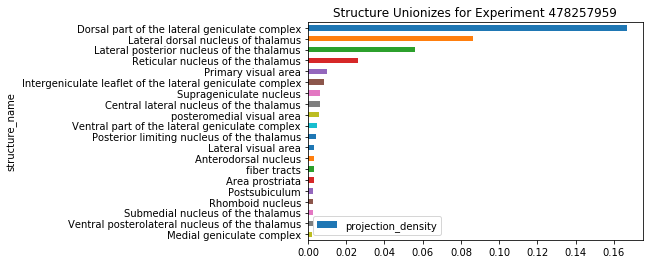

In [37]:
# Plot the 20 structures with the highest projection density in this experiment
unionizes[:20].plot('structure_name', 'projection_density', kind='barh')
plt.gca().invert_yaxis()
plt.title('Structure Unionizes for Experiment %s'%sample_experiment)
##

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #f0f0ff; ">
<h2>Working with data from many experiments</h2>
<p>Instead of looking at a single experiment, you can also obtain all of the unionizes for a given set of experiments.
For example, we can find all the projection unionizes for all injections into VISp in wild type mice.
</p>
</div>

In [38]:
experiment_set = [exp['id'] for exp in experiments if exp['transgenic_line'] == None]
print('number of injections in wild type mice: ', len(experiment_set))
unionizes_set = mcc.get_structure_unionizes(experiment_set,
                                               is_injection = False,
                                                # Look at the summary structure level
                                                structure_ids = summary_structure_ids,
                                               # both hemispheres
                                               hemisphere_ids = [3])
print('length of unionize results: ', len(unionizes_set))

number of injections in wild type mice:  33
length of unionize results:  10428


In [39]:
# We can combine groupby and mean to find the average projection density across experiments for each summary structure
unionizes_set_mean = (
    unionizes_set.groupby('structure_id', as_index = False)['projection_density'].mean()
                        )
print(unionizes_set_mean.shape)

(316, 2)


In [40]:
# Again, add a column with summary structure acronyms so we can interpret the unionizes more easily

names = [name_map[strid] for strid in unionizes_set_mean['structure_id']]
unionizes_set_mean['structure_name'] = names

In [41]:
unionizes_set_mean.sort_values(by = 'projection_density', ascending = False, inplace = True)

Text(0.5, 1.0, 'Average Unionize Data for 33 injections')

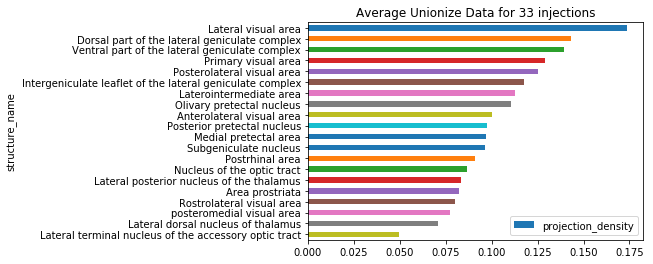

In [42]:
# Plot the 20 structures with the highest average projection density across all wild type VISp injections
unionizes_set_mean[:20].plot('structure_name', 'projection_density', kind='barh')
plt.gca().invert_yaxis()
plt.title('Average Unionize Data for %i injections'%len(experiment_set))

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FFF0; "><h4> Exercise 5: Variability between experiments</h4>

<p>Find the standard deviation and/or SEM for the projection densitiy in the top 20 sources plotted above. Add error bars to the plot.</p>

</div>

In [43]:
# re-generate means so they are in the same order as standard deviation
unionizes_set_mean = (
    unionizes_set.groupby('structure_id', as_index = False)[
    'projection_density'].mean())
print(unionizes_set_mean.shape)

(316, 2)


In [44]:
# generate a second data frame with standard deviations
unionizes_set_std = (
    unionizes_set.groupby('structure_id', as_index = False)[
    'projection_density'].std())
print(unionizes_set_std.shape)

(316, 2)


In [45]:
# find names from structure ids
names = [name_map[strid] for strid in unionizes_set_mean['structure_id']]

In [46]:
# combine names, mean, and standard deviation into one dataframe for easy plotting
set_mean_std = pd.DataFrame({'structure_name': names, 
                            'mean_projection_density': unionizes_set_mean['projection_density'], 
                            'stdev':  unionizes_set_std['projection_density']
                            })

In [47]:
# sort the dataframe to get the top 20 values on top
set_mean_std.sort_values(by = 'mean_projection_density', ascending = False, inplace = True)

In [48]:
# look at the data
set_mean_std.head()

,structure_name,mean_projection_density,stdev
130,Lateral visual area,0.173552,0.172179
49,Dorsal part of the lateral geniculate complex,0.143360,0.109868
52,Ventral part of the lateral geniculate complex,0.139534,0.105376
123,Primary visual area,0.129023,0.100218
135,Posterolateral visual area,0.125154,0.129251


Text(0.5, 1.0, 'Unionize Data for 33 injections (mean +/- SD)')

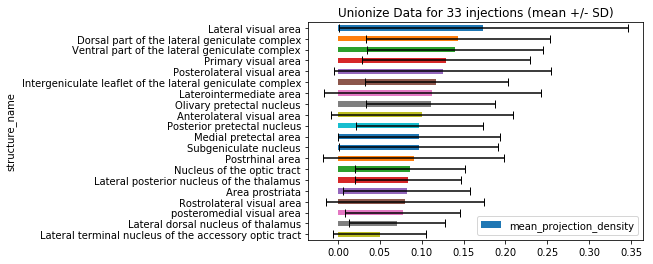

In [49]:
# Plot the 20 structures with the highest average projection density across all wild type VISp injections
set_mean_std[:20].plot('structure_name', 'mean_projection_density', 
                      xerr = 'stdev', capsize = 4, 
                      kind='barh')
plt.gca().invert_yaxis()
plt.title('Unionize Data for %i injections (mean +/- SD)'%len(experiment_set))

In [50]:
# Note that generating a boxplot from a pandas dataframe is often easier and more informative than making a bar plot
top20 = set_mean_std[:20]['structure_name']
names = [name_map[strid] for strid in unionizes_set['structure_id']]
unionizes_set['structure_name'] = names
pltdat = unionizes_set[unionizes_set['structure_name'].isin(top20)]

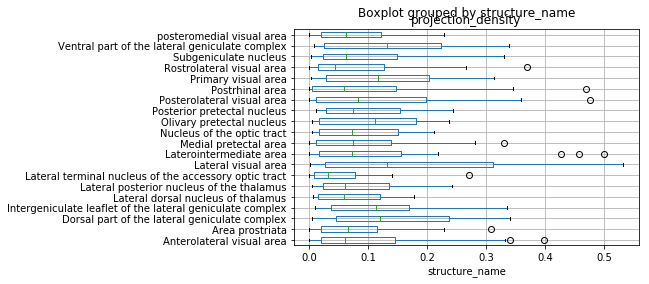

In [51]:
pltdat.boxplot(by = 'structure_name', column = 'projection_density', vert=False)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FFF0; ">
<p>Was the individual experiment we originally plotted representative of the population as a whole?</p>
<ul><li>To compare, we can plot the single experiment and the average of all the wild type expreriments on the same axis</li></ul>
</div>

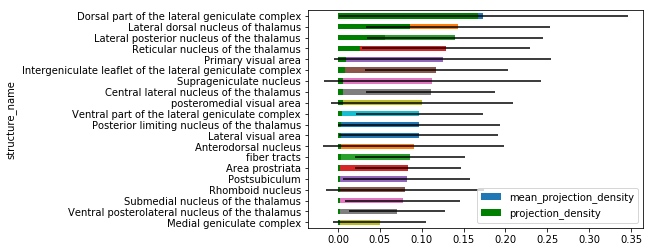

In [52]:
fig, ax = plt.subplots(1)
set_mean_std[:20].plot('structure_name', 'mean_projection_density', xerr = 'stdev', kind = 'barh', ax = ax)
unionizes[:20].plot('structure_name', 'projection_density', color = 'g', kind = 'barh', ax=ax)
plt.gca().invert_yaxis()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FFF0; "><h4> Exercise 6: Comparing projection density and projection volume</h4>

<p>Find the top 20 targets of your region of interest by normalized projection volume.</p>
<ul>
<li>Are these regions different from the top 20 targets by projection density?</li>
<li>Which gives us the correct answer for the top 20 projection targets of primary visual cortex?</li>
</ul>
</div>

In [53]:
# A possible solution
unionizes_set_density = (
    unionizes_set.groupby('structure_id', as_index = False)[
    'projection_density'].mean())
top20_density = (
    unionizes_set_density.sort_values(by = 'projection_density', ascending = False)[:20])

unionizes_set_volume = (
    unionizes_set.groupby('structure_id', as_index = False)[
    'normalized_projection_volume'].mean())
top20_volume = (
    unionizes_set_volume.sort_values(by = 'normalized_projection_volume', ascending = False)[:20])

top20 = top20_density.merge(top20_volume, indicator = True, how='outer')
top20['structure_name'] = [name_map[stid] for stid in top20['structure_id']]

In [54]:
top20

,structure_id,projection_density,normalized_projection_volume,_merge,structure_name
0,409,0.173552,0.500486,both,Lateral visual area
1,170,0.143360,0.288673,both,Dorsal part of the lateral geniculate complex
2,178,0.139534,0.166022,both,Ventral part of the lateral geniculate complex
3,385,0.129023,2.558320,both,Primary visual area
4,425,0.125154,0.252286,both,Posterolateral visual area
5,27,0.117515,NaN,left_only,Intergeniculate leaflet of the lateral genicul...
6,312782574,0.112775,NaN,left_only,Laterointermediate area
7,706,0.110626,NaN,left_only,Olivary pretectal nucleus
8,402,0.100109,0.205577,both,Anterolateral visual area
9,1061,0.097227,NaN,left_only,Posterior pretectal nucleus


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FFF0; ">

Now plot both sets of results. Use all structures that appeared in either of the top-20 lists.

</div>

In [55]:
# The "top20" dataframe contains NaN values where the top 20 structures differed between the two measures, 
# so we will need to go back to our large dataframes to get the missing values before plotting

pltdat = unionizes_set_density.merge(unionizes_set_volume, on = 'structure_id')
pltdat = pltdat[pltdat['structure_id'].isin(top20['structure_id'])]
pltdat = top20[['structure_id', 'structure_name', '_merge']].merge(pltdat, on = ['structure_id'], 
                                                        how = 'outer')

Text(0, 0.5, 'normalized projection volume')

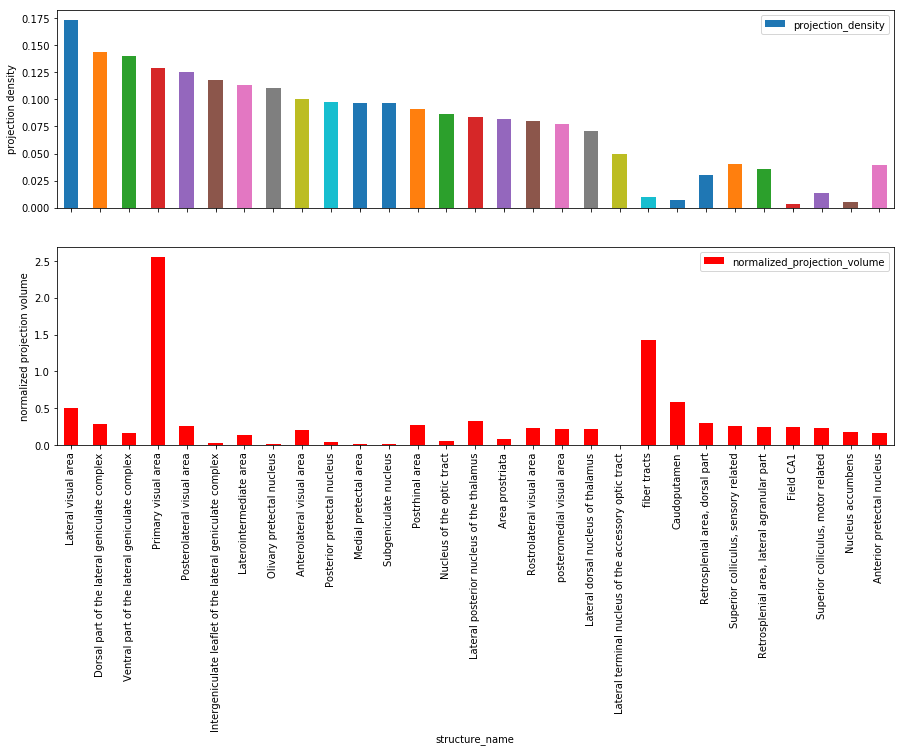

In [56]:
fig, ax = plt.subplots(2, 1, sharex = True, figsize = (15, 8))
pltdat.plot.bar('structure_name', 'projection_density', ax = ax[0])
pltdat.plot.bar('structure_name', 'normalized_projection_volume', ax = ax[1], color = 'r')
ax[0].set_ylabel('projection density')
ax[1].set_ylabel('normalized projection volume')

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #f0f0ff; "><h4>Why do we get different answers with projection density and normalized projection volume?</h4>
<ul>
<li>projection_volume is the volume of projecting signal in mm3 (detected pixels)</li>
<li><u>normalized_projection_volume</u> is the projection_volume / volume of injection site</li>
<li><u>projection_density</u> is the sum of all detected pixels / volume of structure</li>
<li>projection_energy: sum of detected pixel intensity / volume of structure (in general, do not use this)</li>
</ul>

<p>Please see <a href='http://help.brain-map.org/display/mouseconnectivity/API#API-ProjectionDataGridding'>the documentation</a> for more information.</p>

<p>When deciding which measurement to use, think about whether your question is source-centric or target-centric and about how structure sizes might affect your results </p>
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #f0f0ff; ">
<h3><center>Additional excercises</center></h3>
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FFF0; "><h4> Exercise 1: Correlation between experiments</h4>
<p>Get the projection density volumes for two experiments and compute the correlation coefficient between the two.</p>
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FFF0; "><h4>Exercise 2: Comparing wild type projection data with cre-defined projection data.</h4>
<p>Pick a region that has injection experiments in both wild type and cre mice.</p>
<ul>
<li>Determine how many injections in your region of interest were carried out in each transgenic line.</li>
<li>Compare the projections from the cre injection to the wild type projections using the visualization tool of your choice (bar plot, box plot, axis projection, matrix, etc...).</li>
<li>Bonus: How far apart in space are the cre and wild type injections? Would you consider them to be well-matched?</li>
</ul>
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FFF0; "><h4>Exercise 3: Relationship between structure size and projection density</h4>

<p>Because projection density is normalized by the volume of target structures, smaller structures that receive fewer projections overall may show a greater disparity between normalized_projection_volume and projection_density. Is this true for the targets of VISp? What is the relationship between structure size and projection density?</p>
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FFF0; "><h4>Exercise 4: Reciprocal connections</h4>

<p>Of the top 20 projection targets of your favorite region, which ones show reciprocal connections (project back to that region)? Is the strength of the feedback projections proportional to the strength of the feedforward projections?</p>
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FFF0; "><h4> Exercise 5: Generating a Projection Matrix</h4>

<p>The Mouse Connectivity Cache has a built-in function for generating a projection matrix (example below). Use the functions in structure_tree to generate matrices at different levels of detail. Make a projection matrix for:</p>
<ul>
<li>Contralateral projections from VISp</li>
<li>The 293 summary structures</li>
<li>Structures in the thalamus</li>
</ul>
</div>

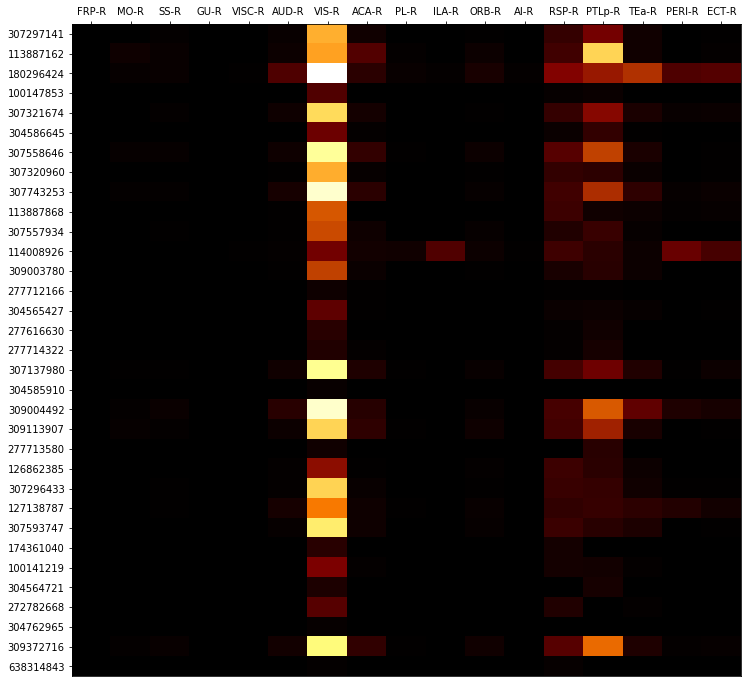

In [57]:
ctx_children = [struct['id'] for struct in structure_tree.children([acronym_to_id_map['Isocortex']])[0]]

pm = mcc.get_projection_matrix(experiment_ids = experiment_set, 
                               projection_structure_ids = ctx_children,
                               hemisphere_ids= [2], # right hemisphere, ipsilateral
                               parameter = 'projection_density')

row_labels = pm['rows'] # these are just experiment ids
column_labels = [ c['label'] for c in pm['columns'] ] 
matrix = pm['matrix']

fig, ax = plt.subplots(figsize=(12,12))
heatmap = ax.pcolor(matrix, cmap=plt.cm.afmhot)

# put the major ticks at the middle of each cell
ax.set_xticks(np.arange(matrix.shape[1])+0.5, minor=False)
ax.set_yticks(np.arange(matrix.shape[0])+0.5, minor=False)

ax.set_xlim([0, matrix.shape[1]])
ax.set_ylim([0, matrix.shape[0]])          

# want a more natural, table-like display
ax.invert_yaxis()
ax.xaxis.tick_top()

ax.set_xticklabels(column_labels, minor=False)
ax.set_yticklabels(row_labels, minor=False)
plt.show()